In [2]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = (SparkSession.builder
            .master("local")
            .appName("bike-prediction")
            .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/16 19:18:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
train_df = (spark.read
            .option('header', 'true')
            .format('csv')
            .load('/kaggle/input/time-series-bike-rents-prediction/train.csv')
           )
test_df = (spark.read
            .option('header', 'true')
            .format('csv')
            .load('/kaggle/input/time-series-bike-rents-prediction/test.csv')
           )
historical_df = (spark.read
            .option('header', 'true')
            .format('csv')
            .load('/kaggle/input/time-series-bike-rents-prediction/historical.csv')
           )

# Target 
**y = 'número total de bicicletas rentadas en los próx 30 dias'**

In [6]:
from pyspark.sql.types import *

def create_dataframe_from_schema(schema):
    empty_RDD = spark.sparkContext.emptyRDD()
    return spark.createDataFrame(empty_RDD, schema)

schema = StructType(
        [
            StructField("date_observacional", DateType(), True)
        ]
    )

In [1]:
from pyspark.sql import DataFrame

class PrepareDatasets:
    
    def __init__(self, historical_df: DataFrame,
        x_key: str, historical_key: str):
        self.historical_df = historical_df
        self.x_key = x_key
        self.historical_key = historical_key
        self.keys = [F.col(f'x_df.{self.x_key}')
              ==F.col(f'historical_df.{self.historical_key}')]
    def _prepare_simple_join(self, x_df: DataFrame, consider_columns: list):
        

        filt_historical_df = (self.historical_df
                                  .select(consider_columns+[self.historical_key])
                             )
        x_new_df = x_df.alias('x_df').join(filt_historical_df
                                     .alias('historical_df'),
                    on=self.keys, how='left')
        
        return x_new_df.drop(self.historical_key)
    
    def _prepare_agg(self, x_df,
                consider_columns: list, dias_comp: list ):
        
        emp_df = create_dataframe_from_schema(schema)
        
        keys = [F.col(f'x_df.{self.x_key}')
              >=F.col(f'historical_df.{self.historical_key}')]
        
        full_df = (x_df.alias('x_df')
                  .join(self.historical_df
                        .alias('historical_df'), 
                on=keys, how='left')
                  .withColumn('diff_days', F.datediff(self.x_key, self.historical_key) )
              )
        
        for days_i in dias_comp:
            for column_i in consider_columns:
                
                filter_df = (full_df.filter(F.col('diff_days')<=days_i)
                                    .groupby(self.x_key)
                                    .agg(
                                       (
                                            F.mean(
                                                F.col(column_i)
                                            )
                                        ).alias(f"mean_{column_i}_last_" + str(days_i) + "_days")
                                        ,
                                        (
                                            F.max(
                                                F.col(column_i)
                                            )
                                        ).alias(f"max_{column_i}_last_" + str(days_i) + "_days")
                                        ,
                                        (
                                            F.stddev(
                                                F.col(column_i)
                                            )
                                        ).alias(f"stddev_{column_i}_last_" + str(days_i) + "_days")
                                        ,
                                        (
                                            F.variance(
                                                 F.col(column_i)
                                             ).alias(f"var_{column_i}_last_" + str(days_i) + "_days")
                                         ),
                                        (
                                            F.min(
                                                F.col(column_i)
                                            )
                                        ).alias(f"min_{column_i}_last_" + str(days_i) + "_days")

                                    )
                            )
                emp_df = emp_df.join(filter_df, on=self.x_key, how='full')
                
        return emp_df
    
    def run_all(self, x_df,
            consider_columns: list, dias_comp: list ):
        
        x_og = x_df.select(self.x_key)
        x_agg_1 = self._prepare_simple_join(x_df, consider_columns)
        x_agg_2 = self._prepare_agg(x_df, consider_columns, dias_comp)
        
        x_new = (x_og
                 .join(x_agg_1, on=[self.x_key], how='left')
                 .join(x_agg_2, on=[self.x_key], how='left')
                )
        return x_new

In [9]:
prepare_dataset = PrepareDatasets(historical_df=historical_df, 
                    x_key='date_observacional', historical_key='dteday')

col_consider = ['temp', 'atemp', 'hum', 'windspeed', 'rents']
dias_consider = [3, 7, 15]

In [10]:
X_train_pro = prepare_dataset.run_all(train_df, col_consider, dias_consider)
X_test_pro = prepare_dataset.run_all(test_df, col_consider, dias_consider)

In [11]:
X_train_pro.write.mode('overwrite').csv('train.csv', header='true')
X_test_pro.write.mode('overwrite').csv('test.csv', header='true')

23/09/16 19:19:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Modelo 

In [12]:
import pandas as pd
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
import plotly.express as px
from sklearn import linear_model
from sklearn.metrics import mean_absolute_percentage_error

In [147]:
test_fe = pd.read_csv('/kaggle/working/test.csv/part-00000-c1a3457f-5c2c-48eb-b344-5868cf9f9780-c000.csv').sort_values("date_observacional").reset_index(drop=True)
train_fe = pd.read_csv('/kaggle/working/train.csv/part-00000-0083b1c5-27a5-4dda-91fa-3d1e45bb3bff-c000.csv').sort_values("date_observacional").reset_index(drop=True)
y_train = pd.read_csv('/kaggle/input/time-series-bike-rents-prediction/y_train_se.csv')

## Como se comporta la serie

In [14]:
px.line(y_train, x='date_observacional', y='rents')

In [171]:
def prediction_plan(prediction, test, metric: mean_absolute_percentage_error):   
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Datos reales', linestyle='-')
    plt.plot(test.index, prediction, label='Predicciones', linestyle='--')
    plt.xlabel('Fecha')
    plt.ylabel('Valor de la serie de tiempo')
    plt.title('Gráfico de Serie de Tiempo y Predicciones')
    plt.legend()
    plt.show()
    

In [172]:
def train_get_score_cv(x_train: pd.DataFrame, y_train: pd.Series, models, 
                       pipeline_engine: Pipeline, features_selected: list=None,
                       k=5, random_state=199) -> pd.DataFrame:
    """
    Obtiente el mape como métrica usando cross validation kfold. El cross validation sirve para simular como 
    el modelo reacciona a datos no observados.
    
    Input:
    x_train[pd.DataFrame]: dataframe que contiene las variables explicativas a entrar en el modelo.
    y_train[pd.Series]: Vector que contiene la variable respuesta.
    models[dict]: Diccionario con los modelos a ser entrenados y evaluados.
    pipeline_engine[Pipeline]: sklearn pipeline --> funciones a ser procesadas en el conjunto de entrenamiento
    k[int]: número de folds en el cross validation
    
    Return:
    Un dataframe con los modelos y la métrica para cada modelo
    """
    if features_selected is None:
        features_selected = x_train.columns
        
    kf = TimeSeriesSplit(n_splits=k, test_size=30)
    result = np.zeros((len(models), 1))
    
    for i,model in enumerate(models.keys()):
    
        mape_metric = []

        learner = models[model]
        print(f'Model: {list(models.keys())[i]}')
        for fold, (id_train, id_test) in enumerate(kf.split(x_train, y_train)):

            Xt = x_train.iloc[id_train]; yt = y_train.iloc[id_train]
            Xv = x_train.iloc[id_test]; yv = y_train.iloc[id_test]
            if pipeline_engine != None:
                preprocess_data_cv = pipeline_engine.fit(Xt, yt)
    
                Xt = preprocess_data_cv.transform(Xt)
                features_selected = Xt.columns
                Xv = preprocess_data_cv.transform(Xv)
            learner.fit(Xt[features_selected], yt.values)
            prediction = pd.Series(learner.predict(Xv[features_selected]), index=Xv.index)   
            mape_fold =  mean_absolute_percentage_error(yv, prediction)
            mape_metric.append(mape_fold)
            print(f'Fold {fold}: Best mape score: {mape_fold}')
            
            prediction_plan(prediction, yv,
                metric=mean_absolute_percentage_error)
                                 
        mape_opt = np.mean(mape_metric)
        
        result[i] = [mape_opt]
    result = pd.DataFrame(result, columns=["MAPE"],index = list(models.keys()))

    return result

def feature_importance_series(train: pd.DataFrame, 
                    y_train: pd.Series, learner = LGBMRegressor()
                    ) -> pd.Series:
    """Retorna un vector de variables ordenadas por su importancia de forma descendiente.
       Toma en consideración la importancia de las variables usando LGBM
    """
    learner.fit(train,y_train.loc[train.index])
    list_features_imp = pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=train.columns).sort_values(ascending=False)
    return list_features_imp

In [16]:
pip install feature-engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.6/326.6 kB 5.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import MeanMedianImputer

random_state = 1997

to_drop = ['date_observacional']
drop_features = DropFeatures(features_to_drop = to_drop)
one_encoder = OneHotEncoder(variables = ['weathersit'], ignore_format=True)
impt = MeanMedianImputer(variables=None, imputation_method='median')

data_pipeliene = Pipeline([ ('drop_features', drop_features),
                            ('one_encoder', one_encoder),
                            ('impt', impt)
                            ])

In [21]:
dados_pipe_df = data_pipeliene.fit_transform(train_fe)
dados_pipe_df['date_observacional'] = train_fe['date_observacional']

In [26]:
import xgboost as xgb


In [27]:
models = {
        'LGBM': LGBMRegressor(random_state=random_state), 
        'LGBM_Poisson': LGBMRegressor(random_state=random_state, objective='poisson'),
        'LGBM_Mape': LGBMRegressor(random_state=random_state, objective='mape'),
        'LGBM_quantile': LGBMRegressor(random_state=random_state, objective='quantile'),
        'LinearRegression' : LinearRegression(),
        'PoissonRegression': linear_model.PoissonRegressor(),
        'XGBoost_poisson': xgb.XGBRegressor(
        base_score=0.5, 
        booster='gbtree',    
        n_estimators=1000,
        objective='count:poisson',
        max_depth=9,
        learning_rate=0.01,
    )
        }

In [28]:
train_get_score_cv(x_train=train_fe,
                   y_train=y_train['rents'],
                   models=models,
                   k=8,
                   pipeline_engine=data_pipeliene)

Model: LGBM
Fold 0: Best mape score: 0.5395805258358303
Fold 1: Best mape score: 0.5272990933480748
Fold 2: Best mape score: 1.6815736534059451
Fold 3: Best mape score: 1.4859405712332052
Fold 4: Best mape score: 0.8572075991705478
Fold 5: Best mape score: 0.3843614512171224
Fold 6: Best mape score: 0.2710789569443274
Fold 7: Best mape score: 7.704482416487669
Model: LGBM_Poisson
Fold 0: Best mape score: 0.48378304530191724
Fold 1: Best mape score: 0.4773247042637176
Fold 2: Best mape score: 1.5630511050740485
Fold 3: Best mape score: 1.4704904683916935
Fold 4: Best mape score: 0.7671383848228448
Fold 5: Best mape score: 0.3982775102067975
Fold 6: Best mape score: 0.2897259407258603
Fold 7: Best mape score: 7.961353394515896
Model: LGBM_Mape
Fold 0: Best mape score: 0.6072964662537133
Fold 1: Best mape score: 0.5106695709074562
Fold 2: Best mape score: 1.3736560631843162
Fold 3: Best mape score: 1.1490042162773582
Fold 4: Best mape score: 0.6778882804930745
Fold 5: Best mape score: 0.3

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning:

invalid value encountered in matmul

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning:

invalid value encountered in matmul



Fold 1: Best mape score: 0.5307850510530169


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning:

invalid value encountered in matmul

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning:

invalid value encountered in matmul



Fold 2: Best mape score: 1.6465965560920113
Fold 3: Best mape score: 3.586341013848236


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning:

invalid value encountered in matmul



Fold 4: Best mape score: 0.8294255623726389


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning:

invalid value encountered in matmul



Fold 5: Best mape score: 0.4046920822933284


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning:

invalid value encountered in matmul



Fold 6: Best mape score: 0.3513081948560733


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:289: RuntimeWarning:

invalid value encountered in matmul



Fold 7: Best mape score: 7.117530214969485
Model: xgb_custom
Fold 0: Best mape score: 0.9145292738885106
Fold 1: Best mape score: 0.8774239794640525
Fold 2: Best mape score: 0.7776837246134128
Fold 3: Best mape score: 0.5880981703557715
Fold 4: Best mape score: 0.8695941920679159
Fold 5: Best mape score: 0.9284152613543557
Fold 6: Best mape score: 0.9323353629184591
Fold 7: Best mape score: 1.2846270701694322


,MAPE
LGBM,1.681441
LGBM_Poisson,1.676393
LGBM_Mape,1.432197
LGBM_quantile,1.971620
LinearRegression,1.392387
PoissonRegression,1.859882
xgb_custom,0.896588


In [35]:
model_final = Pipeline([('data_transformation', data_pipeliene),
                       ('model', xgb.XGBRegressor(
        base_score=0.5, 
        booster='gbtree',    
        n_estimators=500,
        objective='count:poisson',
        max_depth=9,
        learning_rate=0.01,
    ))
                      ])

In [36]:
model_final = model_final.fit(train_fe, y_train['rents'])

In [38]:
y_test = test_fe.sort_values('date_observacional')[['date_observacional']]
y_test['rents'] = model_final.predict(test_fe.sort_values('date_observacional'))
y_test.to_csv('y_test_xgb.csv', index=False)

In [ ]:
y_test

## Improving model

In [51]:
from dateutil.relativedelta import relativedelta
from sklearn.base import BaseEstimator, TransformerMixin

class AggDatesFe(BaseEstimator, TransformerMixin):
    
    def __init__(self: object, fecha_column: str):
        self.fecha_column = fecha_column
    def fit(self, X, y=None):
        return self
        
    def transform(self, X: pd.DataFrame, y=None) -> None:

        X['dayofweek'] = (X[self.fecha_column].apply(lambda x: pd.to_datetime(x) + relativedelta(days=30)).dt.dayofweek
        )
        X['month'] = (X[self.fecha_column].apply(lambda x: pd.to_datetime(x) + relativedelta(days=30)).dt.month
        )
        X['dayofweek_month'] = X["dayofweek"].astype(str) +'_'+ X["month"].astype(str)
        return X

In [67]:
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder, MeanEncoder
from feature_engine.imputation import MeanMedianImputer

random_state = 1997

to_drop = ['date_observacional']
cat_feat = ['dayofweek', 'month', 'dayofweek_month', 'weathersit']

drop_features = DropFeatures(features_to_drop = to_drop)
mean_encoder = MeanEncoder(variables = cat_feat, ignore_format=True)
impt = MeanMedianImputer(variables=None, imputation_method='median')
agg_dates = AggDatesFe(fecha_column='date_observacional')

data_pipeliene_mod = Pipeline([ ('agg_dates', agg_dates),
                                ('drop_features', drop_features),
                                ('mean_encoder', mean_encoder),
                                ('impt', impt)
                            ])

models = {
        'LGBM_Poisson': LGBMRegressor(random_state=random_state,
                                      objective='poisson', boosting='dart', n_estimators=1000),
        'LGBM_Mape': LGBMRegressor(random_state=random_state,
                                   objective='mape', boosting='dart', n_estimators=1000),
        'XGBoost_poisson': xgb.XGBRegressor(
        base_score=0.5, 
        booster='gbtree',    
        n_estimators=1000,
        objective='count:poisson',
        max_depth=9,
        learning_rate=0.01,
    )
        }

In [68]:
import warnings
warnings.filterwarnings("ignore")

In [69]:
train_get_score_cv(x_train=train_fe,
                   y_train=y_train['rents'],
                   models=models,
                   k=8,
                   pipeline_engine=data_pipeliene_mod)

Model: LGBM_Poisson
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 0: Best mape score: 0.4793040921081573
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 1: Best mape score: 0.519172166958294
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 2: Best mape score: 1.1327785369405678
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 3: Best mape score: 1.9848344031316438
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 4: Best mape score: 0.7797005726698996
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 5: Best mape score: 0.33169721368129224
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will b

,MAPE
LGBM_Poisson,2.271386
LGBM_Mape,1.348005
XGBoost_poisson,0.829520


# optimización bayesiana por optuna

In [126]:
import optuna
TRIAL = 5
def objective(trial, x_train=train_fe, y_train=y_train['rents']):
    
    _params = {

        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'random_state': 1997,
        'objective': 'count:poisson'
        }
    
    
    
    model = {'XGB': xgb.XGBRegressor(**_params)}
                 
    result = train_get_score_cv(x_train=x_train,
                                y_train=y_train,
                                models=model,
                                k=8,
                                pipeline_engine=data_pipeliene_mod)

    return result['MAPE'][0]

In [125]:
parameters = {'learning_rate': 0.0320265384344759, 'n_estimators': 10, 
              'reg_alpha': 2, 'reg_lambda': 0,
              'min_data_in_leaf': 17,'random_state': 1997, 'objective' :'mape'}
model = {'LGBM': LGBMRegressor(**parameters)}

In [127]:
study = optuna.create_study(direction = 'minimize')
study.optimize(objective, n_trials = TRIAL)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2023-09-16 20:26:58,861] A new study created in memory with name: no-name-9b4f895e-f637-4a7e-8125-dd7f25041c67


Model: XGB
Fold 0: Best mape score: 0.9634046443639281
Fold 1: Best mape score: 0.9771859200600278
Fold 2: Best mape score: 0.9780742708023048
Fold 3: Best mape score: 0.9795456169454803
Fold 4: Best mape score: 0.9816702896852956
Fold 5: Best mape score: 0.9773831647495856
Fold 6: Best mape score: 1.3074507473891772


[I 2023-09-16 20:27:21,758] Trial 0 finished with value: 1.0136456244359202 and parameters: {'learning_rate': 0.007167350504261231, 'n_estimators': 776, 'min_data_in_leaf': 6}. Best is trial 0 with value: 1.0136456244359202.


Fold 7: Best mape score: 0.9444503414915625
Model: XGB
Fold 0: Best mape score: 0.9724178566451354
Fold 1: Best mape score: 0.9828048884215956
Fold 2: Best mape score: 0.9834744438090756
Fold 3: Best mape score: 0.9845834063957292
Fold 4: Best mape score: 0.9861847852339223
Fold 5: Best mape score: 0.9829535529504353
Fold 6: Best mape score: 1.2153079163557814


[I 2023-09-16 20:27:47,613] Trial 1 finished with value: 1.008232341557513 and parameters: {'learning_rate': 0.005290127749692887, 'n_estimators': 975, 'min_data_in_leaf': 10}. Best is trial 1 with value: 1.008232341557513.


Fold 7: Best mape score: 0.9581318826484296
Model: XGB
Fold 0: Best mape score: 0.9987340580689567
Fold 1: Best mape score: 0.999210793284771
Fold 2: Best mape score: 0.9992415239727113
Fold 3: Best mape score: 0.9992924222013347
Fold 4: Best mape score: 0.9993659209353771
Fold 5: Best mape score: 0.9992176165638138
Fold 6: Best mape score: 0.9846495251062931


[I 2023-09-16 20:28:03,988] Trial 2 finished with value: 0.9972237790784795 and parameters: {'learning_rate': 0.0023118470069128432, 'n_estimators': 327, 'min_data_in_leaf': 9}. Best is trial 2 with value: 0.9972237790784795.


Fold 7: Best mape score: 0.9980783724945782
Model: XGB
Fold 0: Best mape score: 0.997172960733852
Fold 1: Best mape score: 0.9982375823737654
Fold 2: Best mape score: 0.9983062086348543
Fold 3: Best mape score: 0.9984198720560333
Fold 4: Best mape score: 0.9985840058145052
Fold 5: Best mape score: 0.9982528197849809
Fold 6: Best mape score: 0.9657200743459351


[I 2023-09-16 20:28:20,095] Trial 3 finished with value: 0.993800279962153 and parameters: {'learning_rate': 0.005986486493515908, 'n_estimators': 318, 'min_data_in_leaf': 2}. Best is trial 3 with value: 0.993800279962153.


Fold 7: Best mape score: 0.9957087159532979
Model: XGB
Fold 0: Best mape score: 0.9979260204727302
Fold 1: Best mape score: 0.9987070508290847
Fold 2: Best mape score: 0.9987573965962047
Fold 3: Best mape score: 0.9988407826359201
Fold 4: Best mape score: 0.9989611948491078
Fold 5: Best mape score: 0.9987182293363269
Fold 6: Best mape score: 0.9748514762938769


[I 2023-09-16 20:28:36,510] Trial 4 finished with value: 0.9954517460767995 and parameters: {'learning_rate': 0.004335870345835522, 'n_estimators': 337, 'min_data_in_leaf': 5}. Best is trial 3 with value: 0.993800279962153.


Fold 7: Best mape score: 0.9968518176011448
Number of finished trials: 5
Best trial: {'learning_rate': 0.005986486493515908, 'n_estimators': 318, 'min_data_in_leaf': 2}
Best value: 0.993800279962153


In [128]:
optuna.visualization.plot_optimization_history(study)

In [135]:
parameters = {'learning_rate': 0.005986486493515908, 'n_estimators': 318, 
             'random_state': 1997, 'objective': 'count:poisson'}

In [156]:
from darts.models import FFT, AutoARIMA, ExponentialSmoothing, Theta


In [157]:
models = {
        'LGBM_dart': LGBMRegressor(random_state=random_state,
                                      learning_rate=0.01, boosting='dart', n_estimators=500),
        'XGBoost_poisson_opt': xgb.XGBRegressor(**parameters),
        'XGBoost_poisson': xgb.XGBRegressor(
                            base_score=0.5, 
                            booster='gbtree',    
                            n_estimators=1000,
                            objective='count:poisson',
                            max_depth=9,
                            learning_rate=0.01,
                        ),
         "FFT": FFT(nr_freqs_to_keep=None)
        }

In [169]:
import matplotlib.pyplot as plt

Model: LGBM_dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 0: Best mape score: 0.7314923728448145


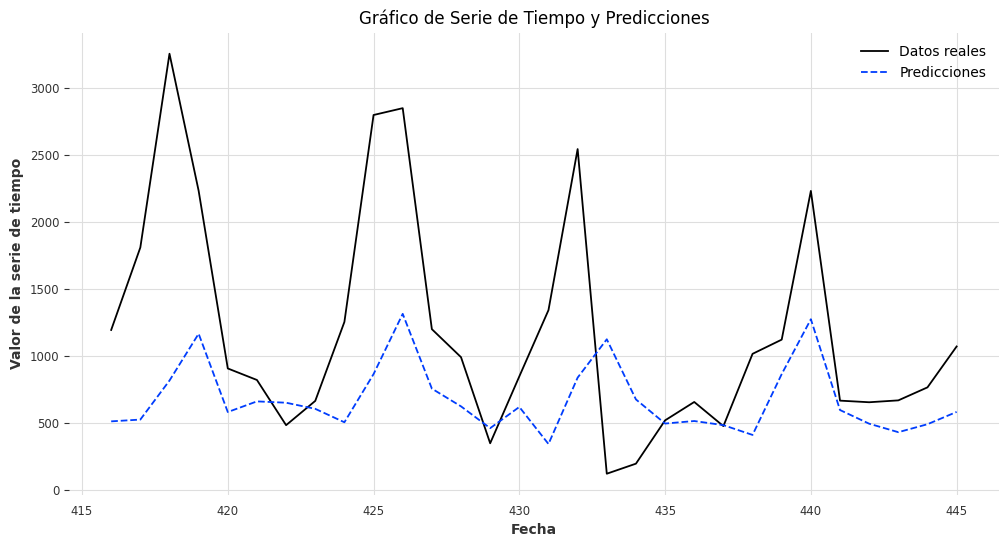

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 1: Best mape score: 0.4249857974233996


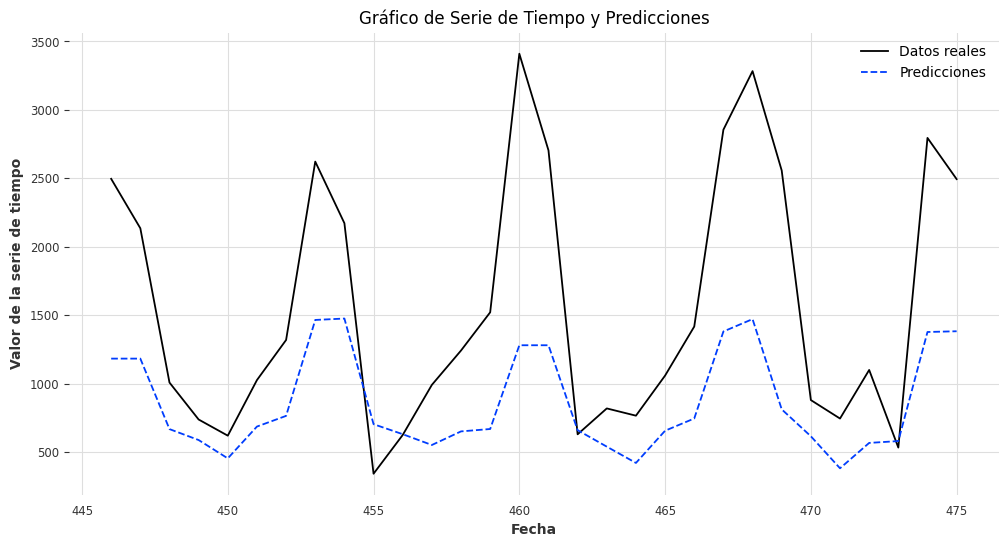

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 2: Best mape score: 0.3773502743510638


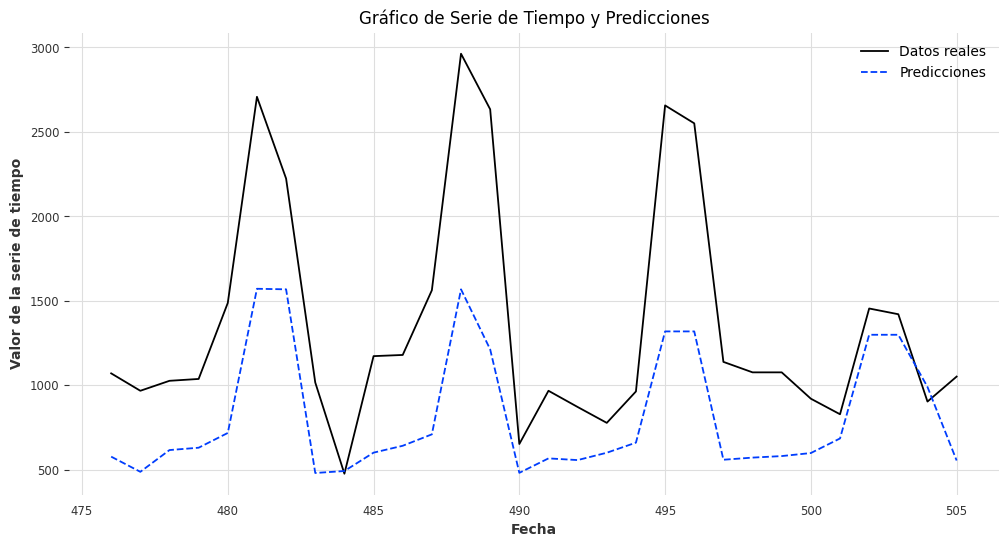

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 3: Best mape score: 0.2891022347627003


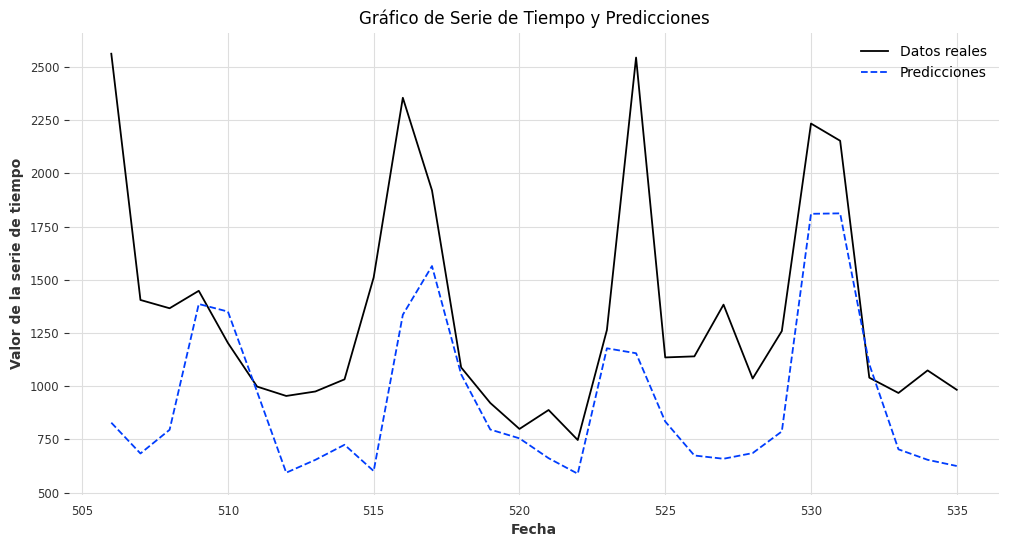

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 4: Best mape score: 0.49507380820706776


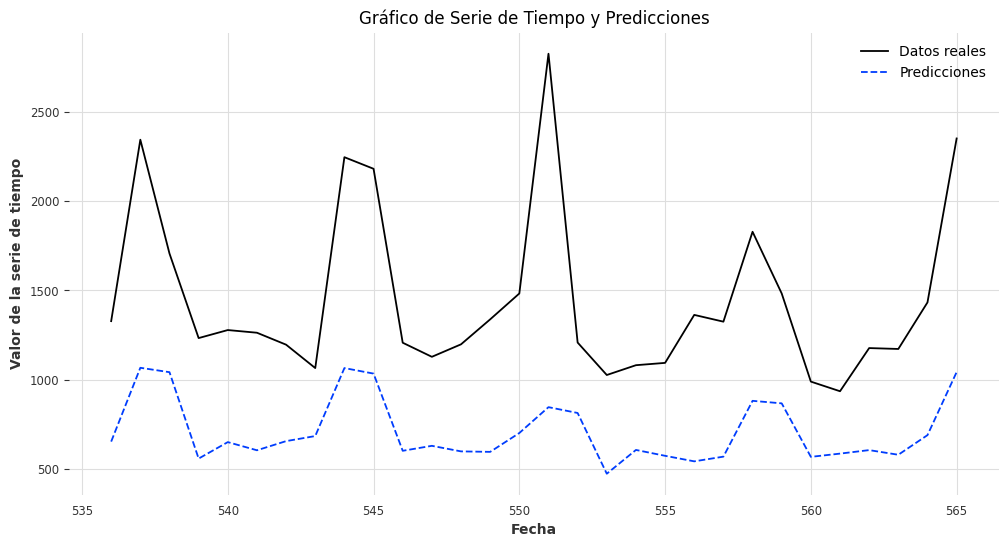

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 5: Best mape score: 0.44702279431946934


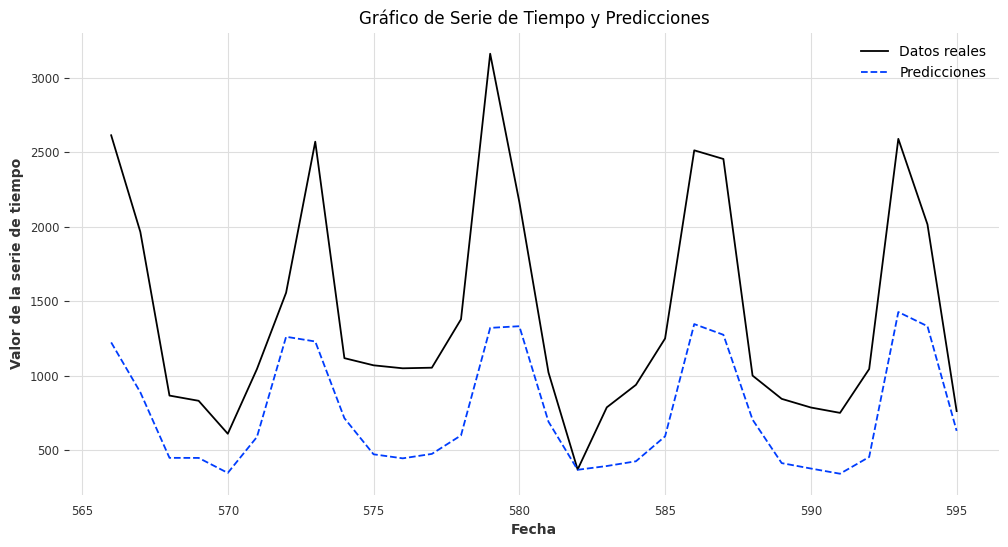

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 6: Best mape score: 10.375092156154414


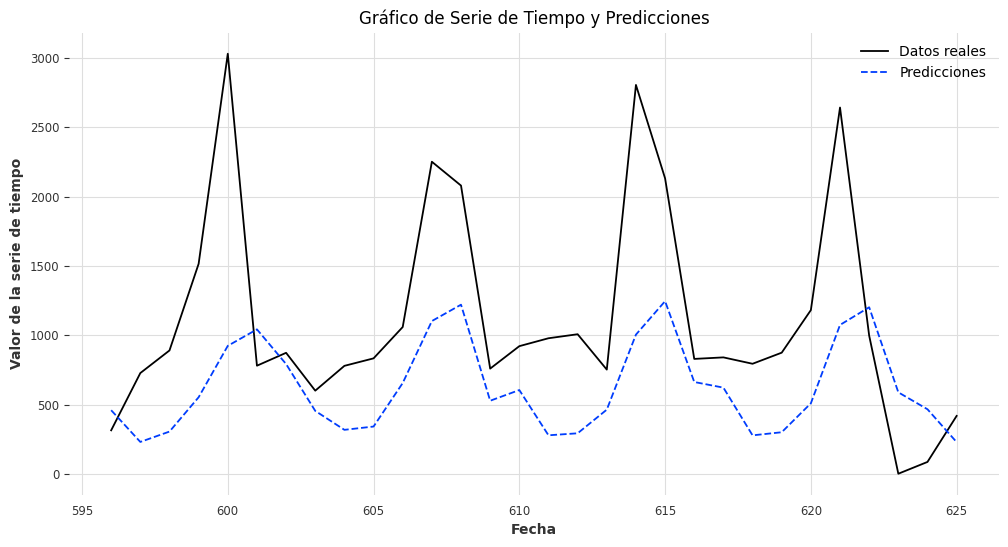

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
Fold 7: Best mape score: 0.49576205415277186


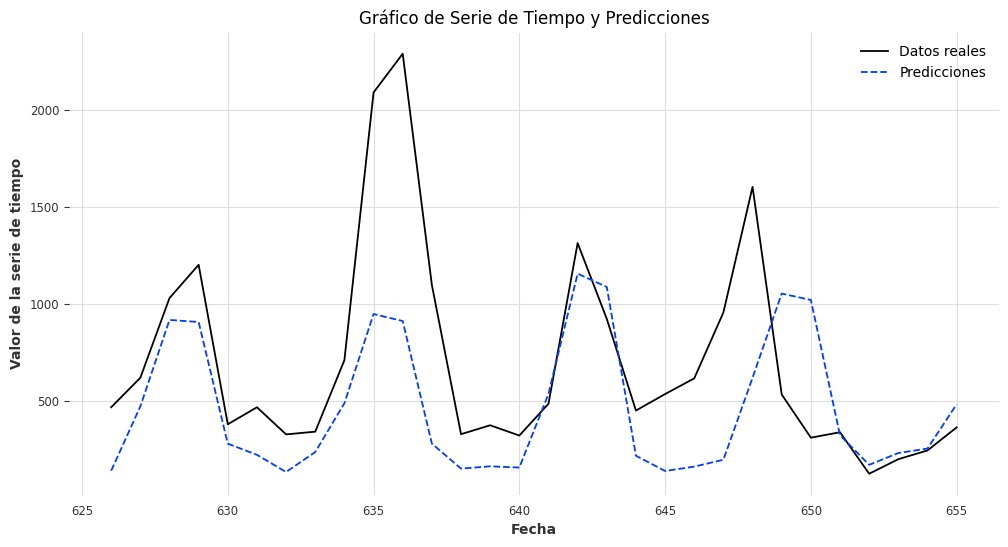

Model: XGBoost_poisson_opt
Fold 0: Best mape score: 0.997172960733852


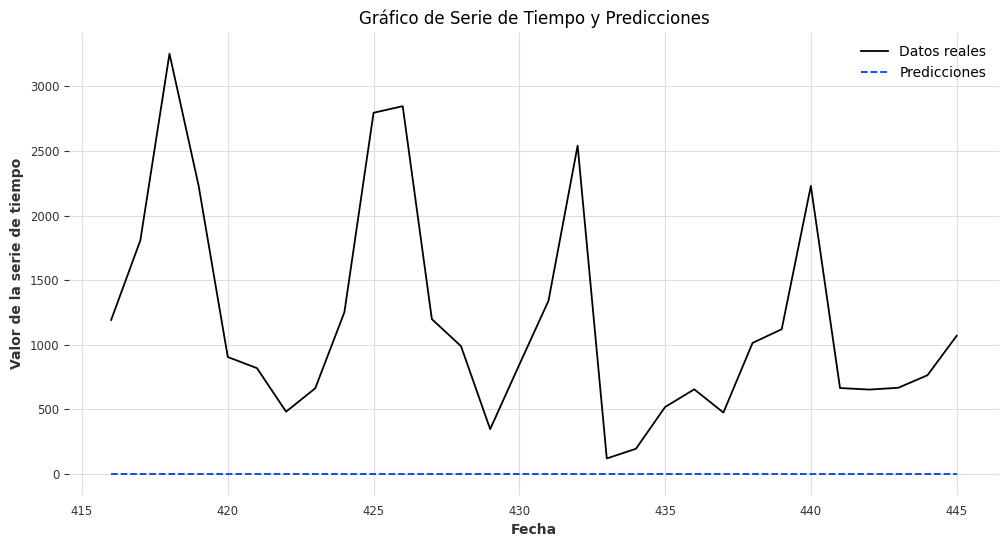

Fold 1: Best mape score: 0.9982375823737654


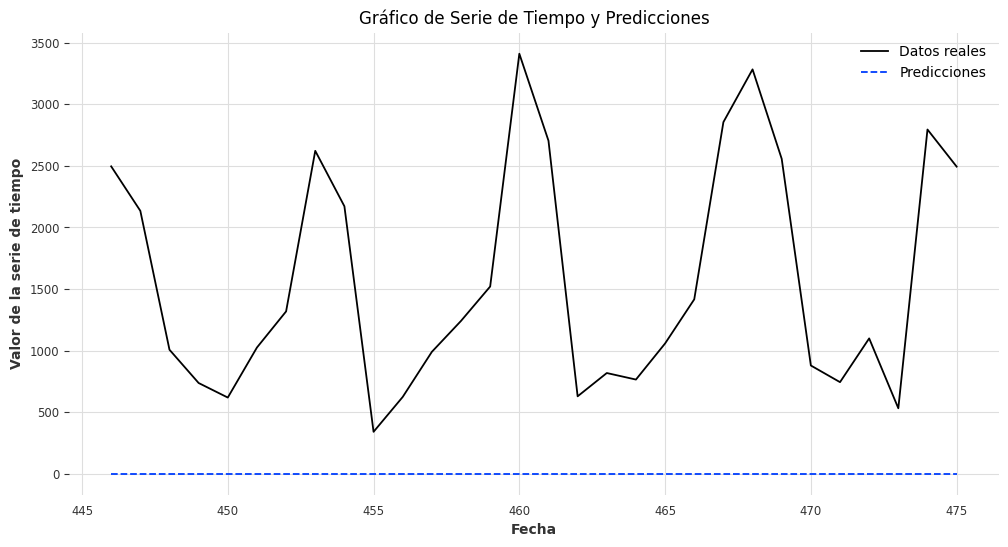

Fold 2: Best mape score: 0.9983062086348543


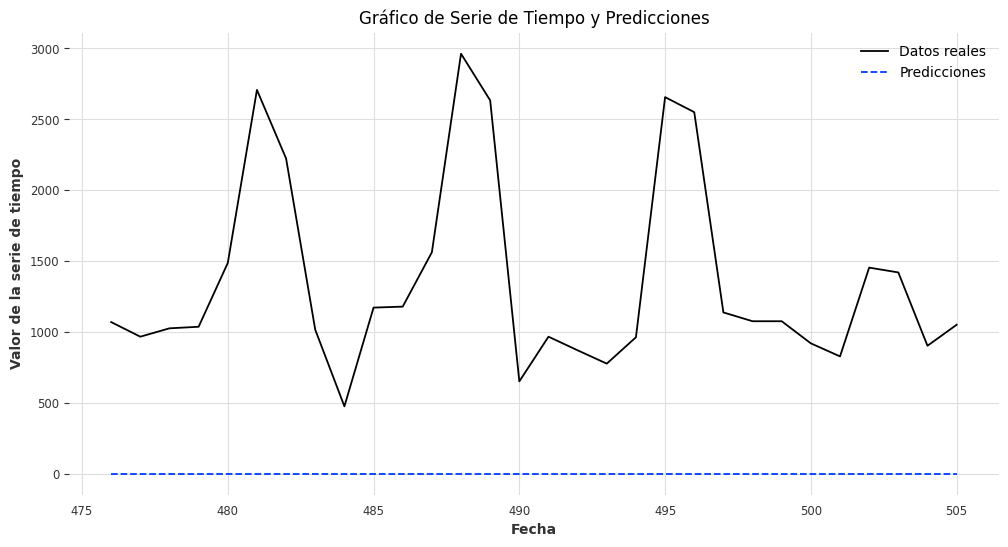

Fold 3: Best mape score: 0.9984198720560333


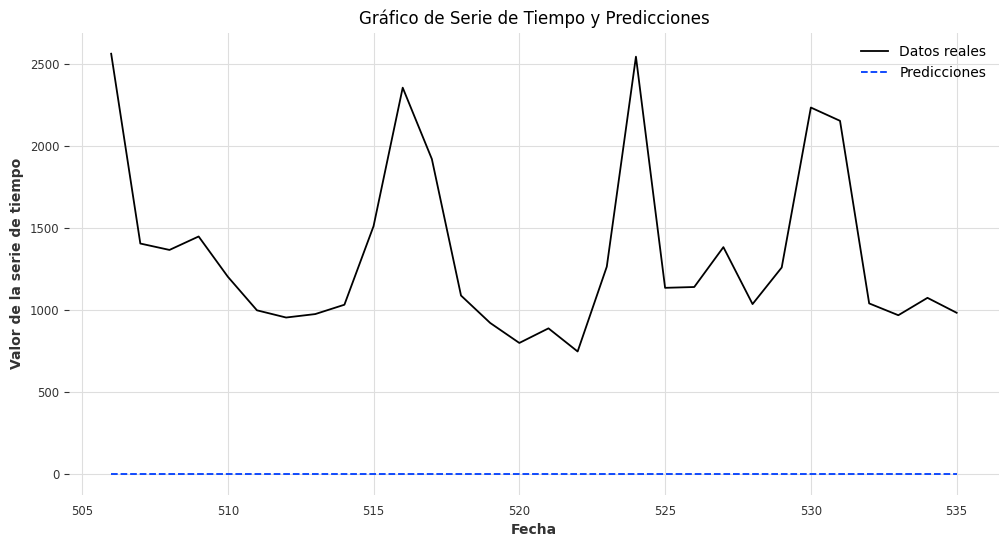

Fold 4: Best mape score: 0.9985840058145052


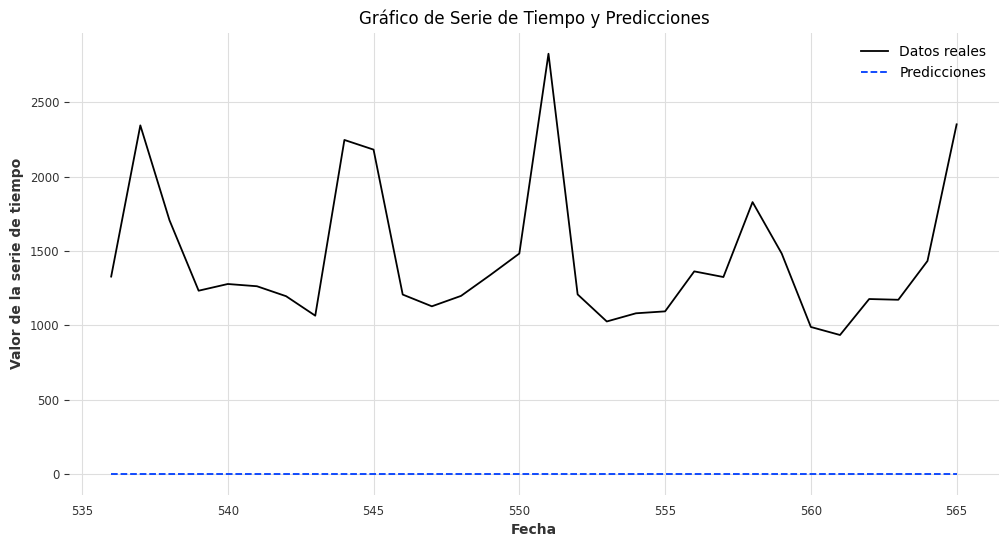

Fold 5: Best mape score: 0.9982528197849809


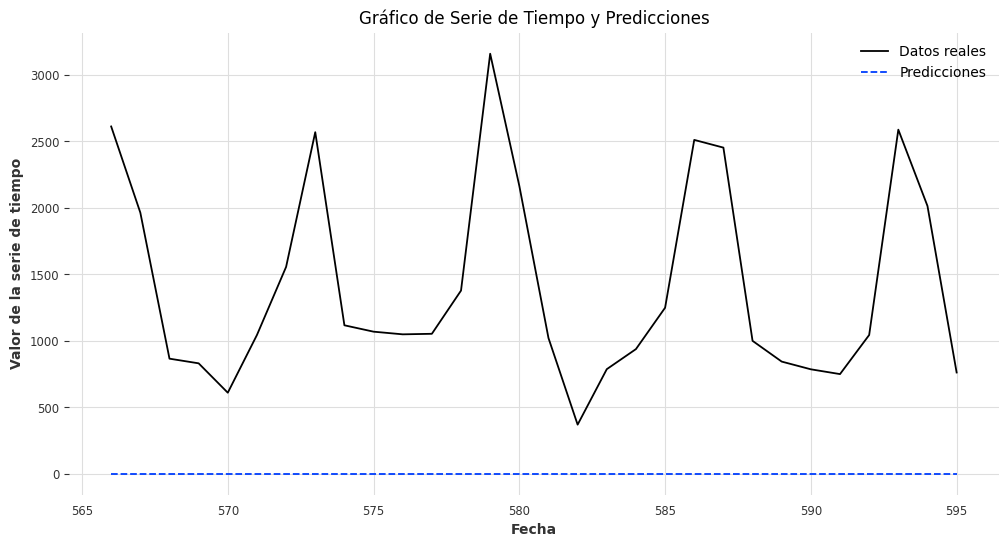

Fold 6: Best mape score: 0.9657200743459351


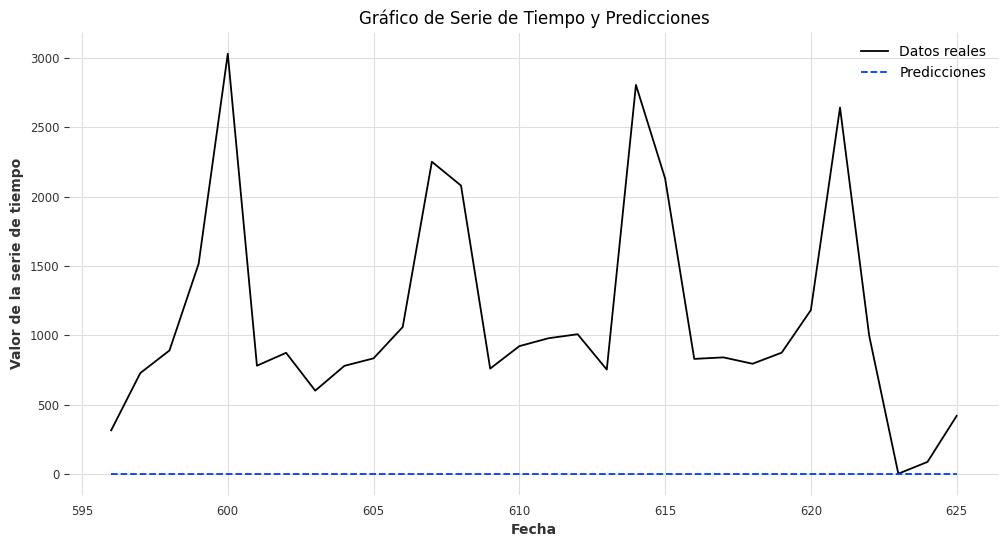

Fold 7: Best mape score: 0.9957087159532979


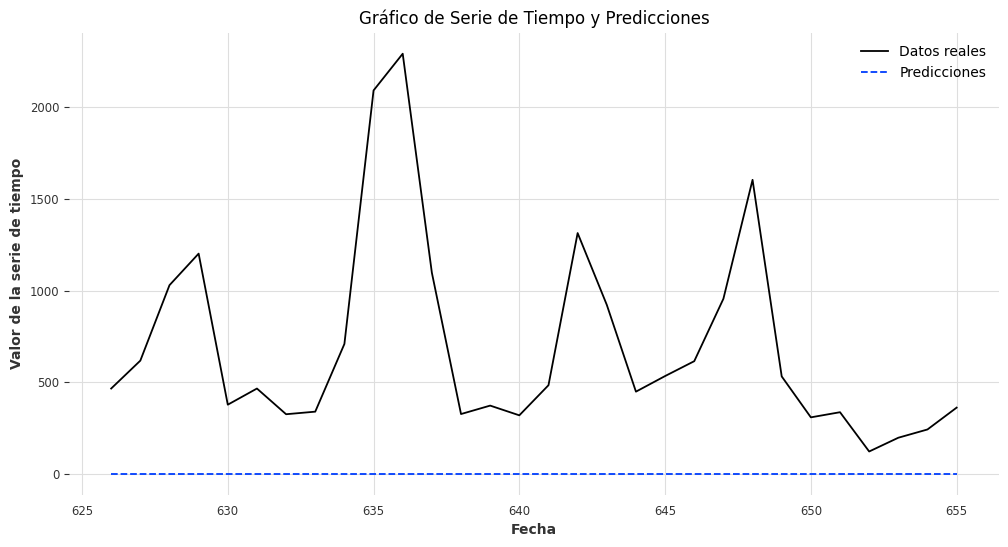

Model: XGBoost_poisson
Fold 0: Best mape score: 0.591425201171262


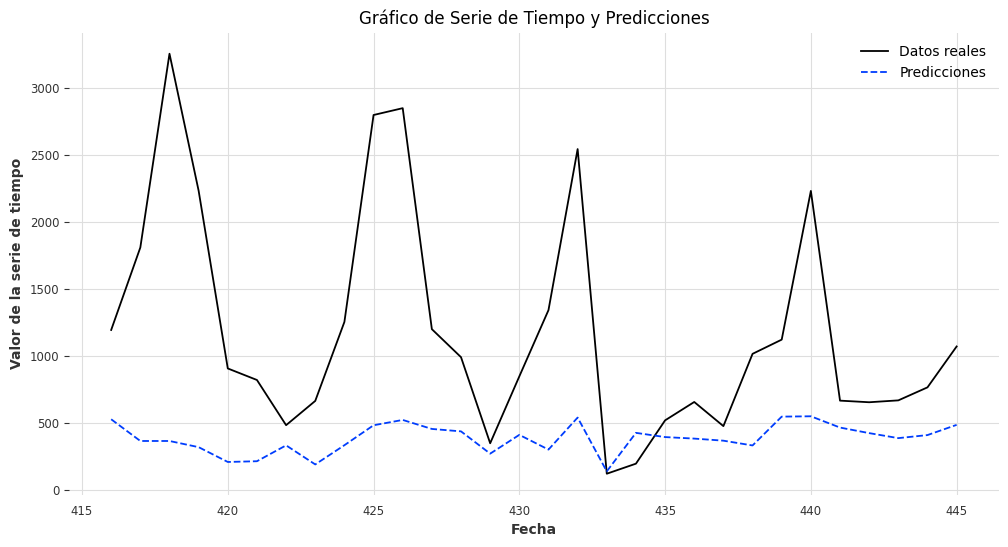

Fold 1: Best mape score: 0.6420706357063078


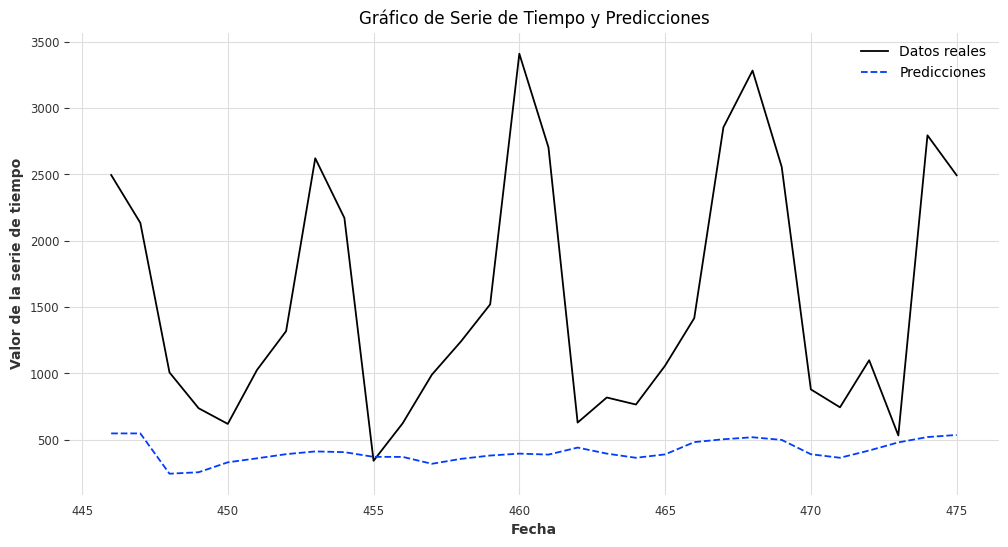

Fold 2: Best mape score: 0.626230582532338


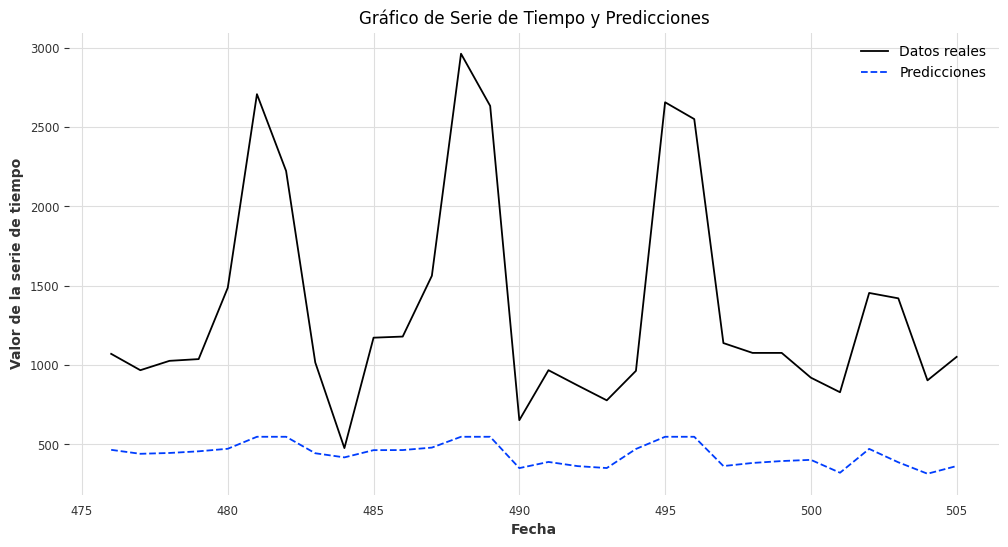

Fold 3: Best mape score: 0.5986251757714351


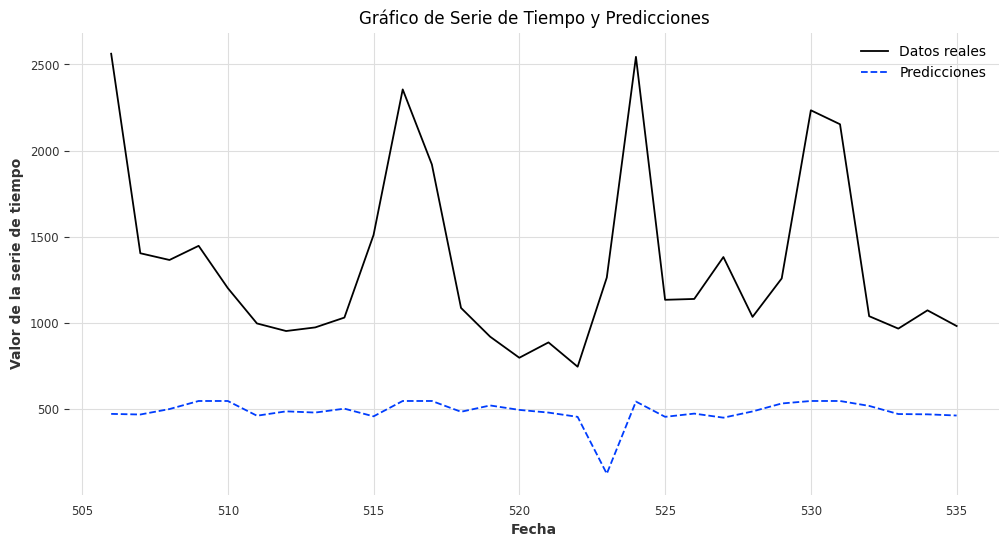

Fold 4: Best mape score: 0.6398147755043018


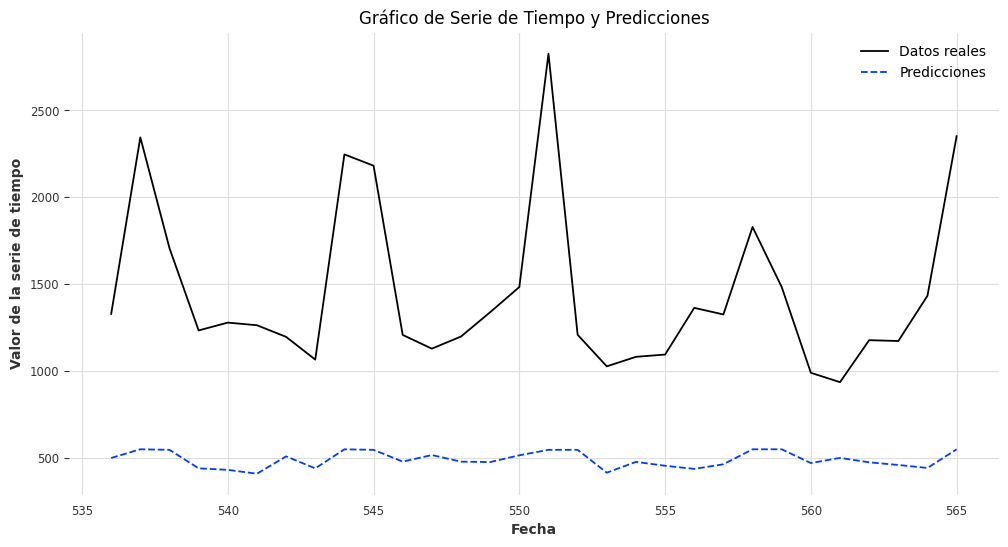

Fold 5: Best mape score: 0.6026427158095743


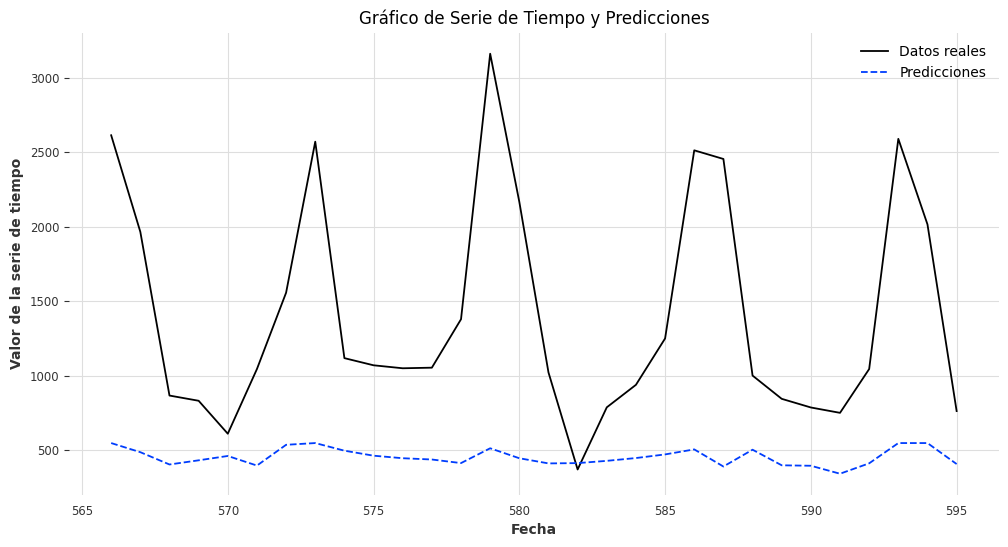

Fold 6: Best mape score: 3.8858852764448346


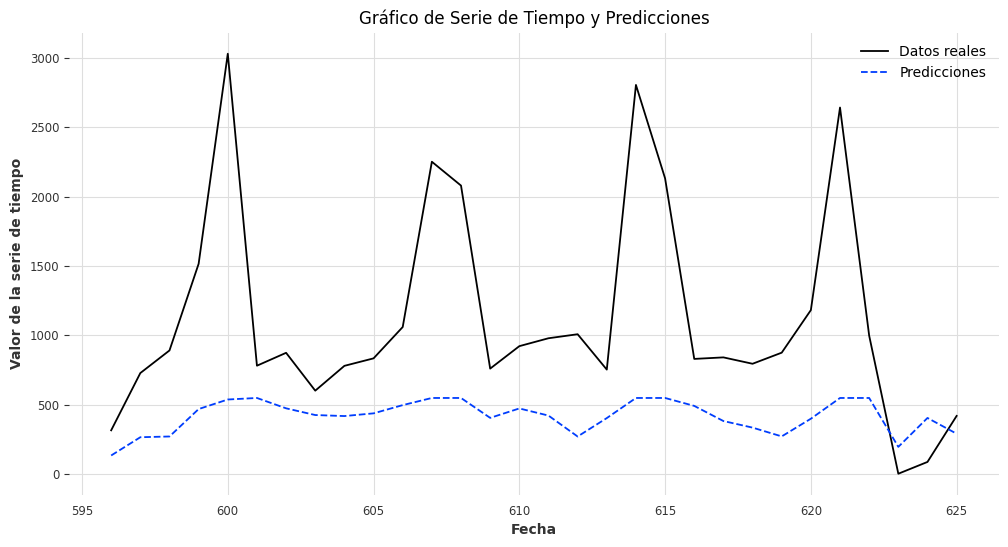

Fold 7: Best mape score: 0.4344208022053687


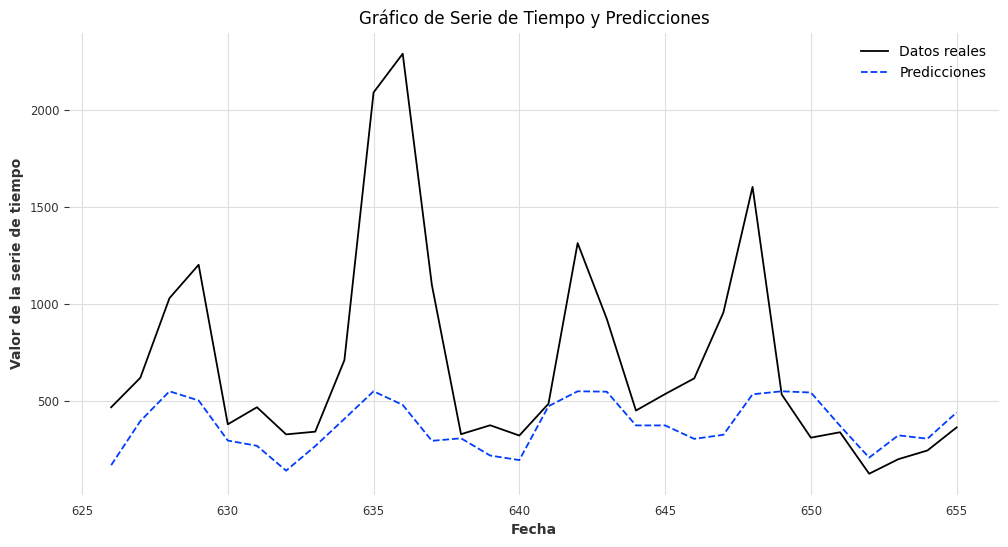

Model: FFT


TypeError: FFT.fit() takes 2 positional arguments but 3 were given

In [173]:
train_get_score_cv(x_train=train_fe,
                   y_train=y_train['rents'],
                   models=models,
                   k=8,
                   pipeline_engine=data_pipeliene_mod)

In [189]:
data_pipeliene_mod = data_pipeliene_mod.fit(train_fe, y_train['rents'])

In [182]:
from darts.datasets import TemperatureDataset
ts = TemperatureDataset().load()


In [186]:
from darts.models.forecasting.xgboost import XGBModel

In [190]:

model = XGBModel(
    lags=12,
    lags_past_covariates=12,
    lags_future_covariates=[0, 1, 2, 3, 4, 5],
    output_chunk_length=6,
)

model.fit(y_train['rents'], past_covariates=data_pipeliene_mod.transform(train_fe), future_covariates=data_pipeliene_mod.transform(test_fe))

pred = model.predict(6)
print(pred.values())

AttributeError: 'numpy.int64' object has no attribute 'static_covariates'

# modelo final

In [136]:
model_pipe = Pipeline([('prep',data_pipeliene_mod),
                       ('modelo', xgb.XGBRegressor(**parameters))
                      ])


In [137]:
model_pipe = model_pipe.fit(train_fe, y_train['rents'])

In [149]:
y_test = test_fe.sort_values('date_observacional')[['date_observacional']]
y_test['rents'] = model_pipe.predict(test_fe.sort_values('date_observacional'))
y_test.to_csv('y_test_xgb_opt.csv', index=False)

In [152]:
y_train

,date_observacional,rents
0,2011-01-15,208
1,2011-01-16,140
2,2011-01-17,218
3,2011-01-18,259
4,2011-01-19,579
...,...,...
651,2012-10-27,337
652,2012-10-28,123
653,2012-10-29,198
654,2012-10-30,243
